---
title: Un dataset de reservas internacionales
subtitle: Desde los reportes semanales del BCB
date: 2026-01-22
--- 

## Cómo extraer datos de los reportes

In [313]:
import pandas as pd
from datetime import datetime as dt
import numpy as np
import re
from calendar import monthrange
import os
from pathlib import Path
from plotnine import * 
from mizani import palettes
from IPython.display import clear_output

pd.options.display.max_colwidth = 200

En este cuaderno extraemos valores para reservas internacionales de reportes semanales del Banco Central de Bolivia. Hasta fines de 2025 son más de 900 reportes.

Primero descargo todos los reportes disponibles en formato `xls` y `xlsx` del portal del BCB a una carpeta `temporal`. Para extraer datos de cada reporte, leo cada documento excel y construyo una tabla simple con los datos de su primera hoja. La función `read_xlsx` retorna esta tabla exitosamente para la gran mayoría de reportes.  

In [196]:
def read_xlsx(fn):
    """
    Lee el reporte semanal y retorna una tabla simple con un índice de variables y una columna por fecha.
    Funciona para la mayoría, NO TODAS, de fechas del reporte.
    """

    def identify_date(header_col):
        meses_corto = "Ene|Feb|Mar|Abr|May|Jun|Jul|Ago|Sep|Oct|Nov|Dic"
        meses_corto_mayus = "ENE|FEB|MAR|ABR|MAY|JUN|JUL|AGO|SEP|OCT|NOV|DIC"
        meses_completo = "Enero|Febrero|Marzo|Abril|Mayo|Junio|Julio|Agosto|Septiembre|Octubre|Noviembre|Diciembre"
        meses_weird = {"adr": 4}
        meses_str = "|".join(
            [meses_completo, meses_corto, "|".join(meses_weird.keys())]
        )
        meses_lists = [
            {m: i + 1 for i, m in enumerate(meses_list.split("|"))}
            for meses_list in [meses_corto, meses_completo, meses_corto_mayus]
        ] + [meses_weird]
        meses = {}
        for d in meses_lists:
            meses.update(d)
        for cell in header_col:
            if type(cell) == dt:
                return cell
            elif type(cell) == str:
                matches = re.search(
                    rf"(\d{{4}}).*({meses_str})", cell, re.IGNORECASE | re.DOTALL
                )
                if matches:
                    year = int(matches.group(1))
                    month = meses[matches.group(2)]
                    last_day = monthrange(year, month)[1]
                    return dt(year, month, last_day)

    def identify_variables(index):
        variables = []
        category = ""
        for i, row in index.iterrows():
            variable = ""
            try:
                if type(row.iloc[-2]) == str:
                    category = row.iloc[-2].strip()
                if type(row.iloc[-1]) == str:
                    variable = row.iloc[-1].strip()
                variables.append({"categoria": category, "variable": variable})
            except Exception as e:
                print(row)
        return variables[1:]

    def classify_cell(x):
        if pd.isna(x):
            return "empty"
        elif isinstance(x, (int, float)):
            return "numeric"
        elif isinstance(x, str):
            return "text"
        elif isinstance(x, dt):
            return "datetime"
        else:
            return "other"

    def find_bbox(tipos_df, tipo, row_threshold, col_threshold):
        is_tipo = tipos_df.map(lambda x: x == tipo)

        row_density = is_tipo.sum(axis=1) / len(is_tipo.columns)
        col_density = is_tipo.sum(axis=0) / len(is_tipo.index)

        tipo_rows = row_density >= row_threshold
        tipo_cols = col_density >= col_threshold

        row_indices = np.where(tipo_rows)[0]
        col_indices = np.where(tipo_cols)[0]

        if len(row_indices) == 0 or len(col_indices) == 0:
            return None

        return {
            "row": {
                "start": row_indices.min(),
                "end": row_indices.max() + 1,
            },
            "col": {"start": col_indices.min(), "end": col_indices.max() + 1},
        }

    df = pd.read_excel(fn, header=None)

    tdf = df.map(classify_cell)
    n = find_bbox(tdf, "numeric", 0.3, 0.3)

    values = df.iloc[
        n["row"]["start"] : n["row"]["end"],
        n["col"]["start"] : n["col"]["end"],
    ].copy()
    header = df.iloc[: n["row"]["start"], n["col"]["start"] : n["col"]["end"]].copy()
    dates = [identify_date(header[col]) for col in header.columns]

    valid_indices = [i for i, d in enumerate(dates) if d is not None]
    dates = [dates[i] for i in valid_indices]
    values = values.iloc[:, valid_indices]
    header = header.iloc[:, valid_indices]

    index = df.iloc[n["row"]["start"] - 1 : n["row"]["end"], : n["col"]["start"]].copy()
    variables = identify_variables(index)

    limpio = pd.concat(
        [
            pd.DataFrame(variables),
            pd.DataFrame(
                values.values,
                columns=dates,
            ),
        ],
        axis=1,
    ).set_index(["categoria", "variable"])
    limpio = limpio[limpio.index.get_level_values("variable") != ""]
    limpio = limpio[(limpio.isna().sum(axis=1) / limpio.shape[1]) < 1]
    clear_output(wait=True)
    print(f"{fn}: una tabla con {limpio.shape[0]} filas")
    return limpio

Convierto esta tabla en una tabla vertical con 4 columnas: `categoria`, `variable`, `fecha` y `valor`.

In [96]:
def melt_df(dfi):
    dfi_long = (
        dfi.reset_index()
        .melt(id_vars=["categoria", "variable"], var_name="fecha", value_name="valor")
        .dropna(subset=["valor"])
    )
    dfi_long["fecha"] = pd.to_datetime(dfi_long["fecha"])
    dfi_long["valor"] = pd.to_numeric(dfi_long["valor"], errors="coerce")
    return dfi_long

Con la tabla vertical debo empalmar cada serie de interés con su serie histórica. Cómo identificamos la serie de divisas o de oro entre todas las series de un reporte? Primero intenté una aproximación basada sólo en datos, comparando cada serie con una serie de referencia en un set de fechas comunes. Si cada valor coincidía o existía una correlación muy alta, asumía que eran la misma serie y las empalmaba. Sin embargo, este proceso era demasiado frágil. Considerando que sólo debo identificar un set pequeño de series (`Divisas`, `Oro`, `DEG`, `Posición con el FMI` y `Otros`), intento algo mucho más sencillo. Primero limito mi búsqueda a las series en la categoría "Operaciones con el exterior" y ahí identifico series por secciones de los nombres de cada columna. Asumo que sólo existen estos 5 tipos de reservas internacionales en el periodo de interés y que, para considerarse completo debo identificar al menos 4 de estos 5 tipos en un mismo documento. Defino estas reglas luego de varias corridas de prueba e inspección manual de documentos. 

In [261]:
def extraer_reservas(xlsx):
    nuevas_reservas = []
    for col in ["categoria", "variable"]:
        xlsx[col] = xlsx[col].str.strip().str.lower()
    xlsx = xlsx[xlsx.categoria.str.contains("^operaciones con el exterior")].copy()
    for tipo, query in zip(
        ["Divisas", "DEG", "Oro", "Posición con el FMI", "Otros"],
        ["^divisas", "^deg", "^oro", "^posición", "^otros"],
    ):
        serie = xlsx[xlsx.variable.str.contains(query)].copy()
        # print(query)
        if len(serie) > 0:
            serie["tipo"] = tipo
            nuevas_reservas.append(serie[["tipo", "fecha", "valor"]])
    clear_output(wait=True)
    print(f"{len(nuevas_reservas)} variables encontradas")
    if len(nuevas_reservas) >= 4:
        return pd.concat(nuevas_reservas)
    else:
        return []


## Un proceso iterativo

Comienzo corriendo este proceso sobre todos los documentos excel disponibles.

In [56]:
base = Path("temporal") # El directorio con todos los documentos excel

In [198]:
xlsx_files = sorted(
    [f for f in os.listdir(base) if f.endswith((".xlsx", ".xls"))], reverse=True
)[2:]
xlsx_files[0]

'informacion-estadistica-semanal_2025-12-24.xlsx'

Construyo sobre los datos que ya tengo disponibles.

In [199]:
# Seed
reservas = pd.read_parquet("reservas.parquet")
reservas

,tipo,fecha,valor
0,Divisas,2008-12-31,6871.362961
1,Divisas,2009-01-31,6901.560283
2,Divisas,2009-02-28,6763.934585
3,Divisas,2009-03-31,6871.923461
4,Divisas,2009-04-30,6864.808979
...,...,...,...
935,Posición con el FMI,2026-01-12,35.622470
936,Posición con el FMI,2026-01-13,35.667626
937,Posición con el FMI,2026-01-14,35.644396
938,Posición con el FMI,2026-01-15,35.625081


Mantengo un log donde noto en qué documentos tengo problemas.

In [200]:
log = []

In [314]:
#| echo: false

for fn in xlsx_files:
    xlsx = melt_df(read_xlsx(base / fn))
    dfi = extraer_reservas(xlsx)
    success = len(dfi) > 0
    if success:
        reservas = pd.concat([reservas, dfi]).drop_duplicates(
            subset=["tipo", "fecha"], keep="first"
        )
    log.append({"fn": fn, "success": success})

Una vez terminada una corrida inicial, computo cuántos errores tengo por año, investigo por qué y, si es posible, arreglo mi proceso para expandir su cobertura. 

In [265]:
logdf = pd.DataFrame(log)
logdf.drop_duplicates(subset=["fn"], keep="last")
logdf["fecha"] = pd.to_datetime(logdf.fn.str.extract(r"(\d{4}-\d{2}-\d{2})")[0])
logdf.groupby(
    [pd.Grouper(key="fecha", freq="YE"), "success"], as_index=False
).size().pivot_table(index="fecha", columns="success", values="size").fillna(0).astype(int)

success,False,True
fecha,,
2004-12-31,36,0
2005-12-31,94,0
2006-12-31,94,0
2007-12-31,70,26
2008-12-31,45,45
2009-12-31,46,46
2010-12-31,48,48
2011-12-31,52,52
2012-12-31,50,50


Y vuelvo a correr sobre los casos donde tengo errores. Repito este proceso hasta estar satisfecho.

In [315]:
#| echo: false

for fn in logdf[~logdf.success].fn.tolist():
    xlsx = melt_df(read_xlsx(base / fn))
    dfi = extraer_reservas(xlsx)
    success = len(dfi) > 0
    if success:
        reservas = pd.concat([reservas, dfi]).drop_duplicates(
            subset=["tipo", "fecha"], keep="first"
        )
    log.append({"fn": fn, "success": success})

## Exploración y guardado

Primero me aseguro que sólo exista un valor por fecha y tipo de reserva.

In [363]:
reservas.fecha = reservas.fecha.dt.normalize()
reservas = reservas.drop_duplicates(subset=["tipo", "fecha"])

Y que sólo existan valores no nulos.

In [375]:
reservas = reservas[reservas.valor.notna()]

Estimo algunos números para describir mi dataset. Por ejemplo, cuántos registros tengo por tipo de reserva y año.

In [376]:
reservas.groupby(
    [pd.Grouper(key="fecha", freq="YE"), "tipo"], as_index=False
).size().pivot_table(index="fecha", columns="tipo", values="size").fillna(0).astype(int)

tipo,DEG,Divisas,Oro,Otros,Posición con el FMI
fecha,,,,,
2003-12-31,1,1,1,1,0
2005-12-31,12,12,12,12,0
2006-12-31,12,12,12,12,0
2007-12-31,141,141,141,141,0
2008-12-31,235,235,235,235,1
2009-12-31,222,222,222,222,12
2010-12-31,234,234,234,234,12
2011-12-31,256,256,256,256,12
2012-12-31,243,243,243,243,12


Un gráfico de áreas a manera de test de olfato. 

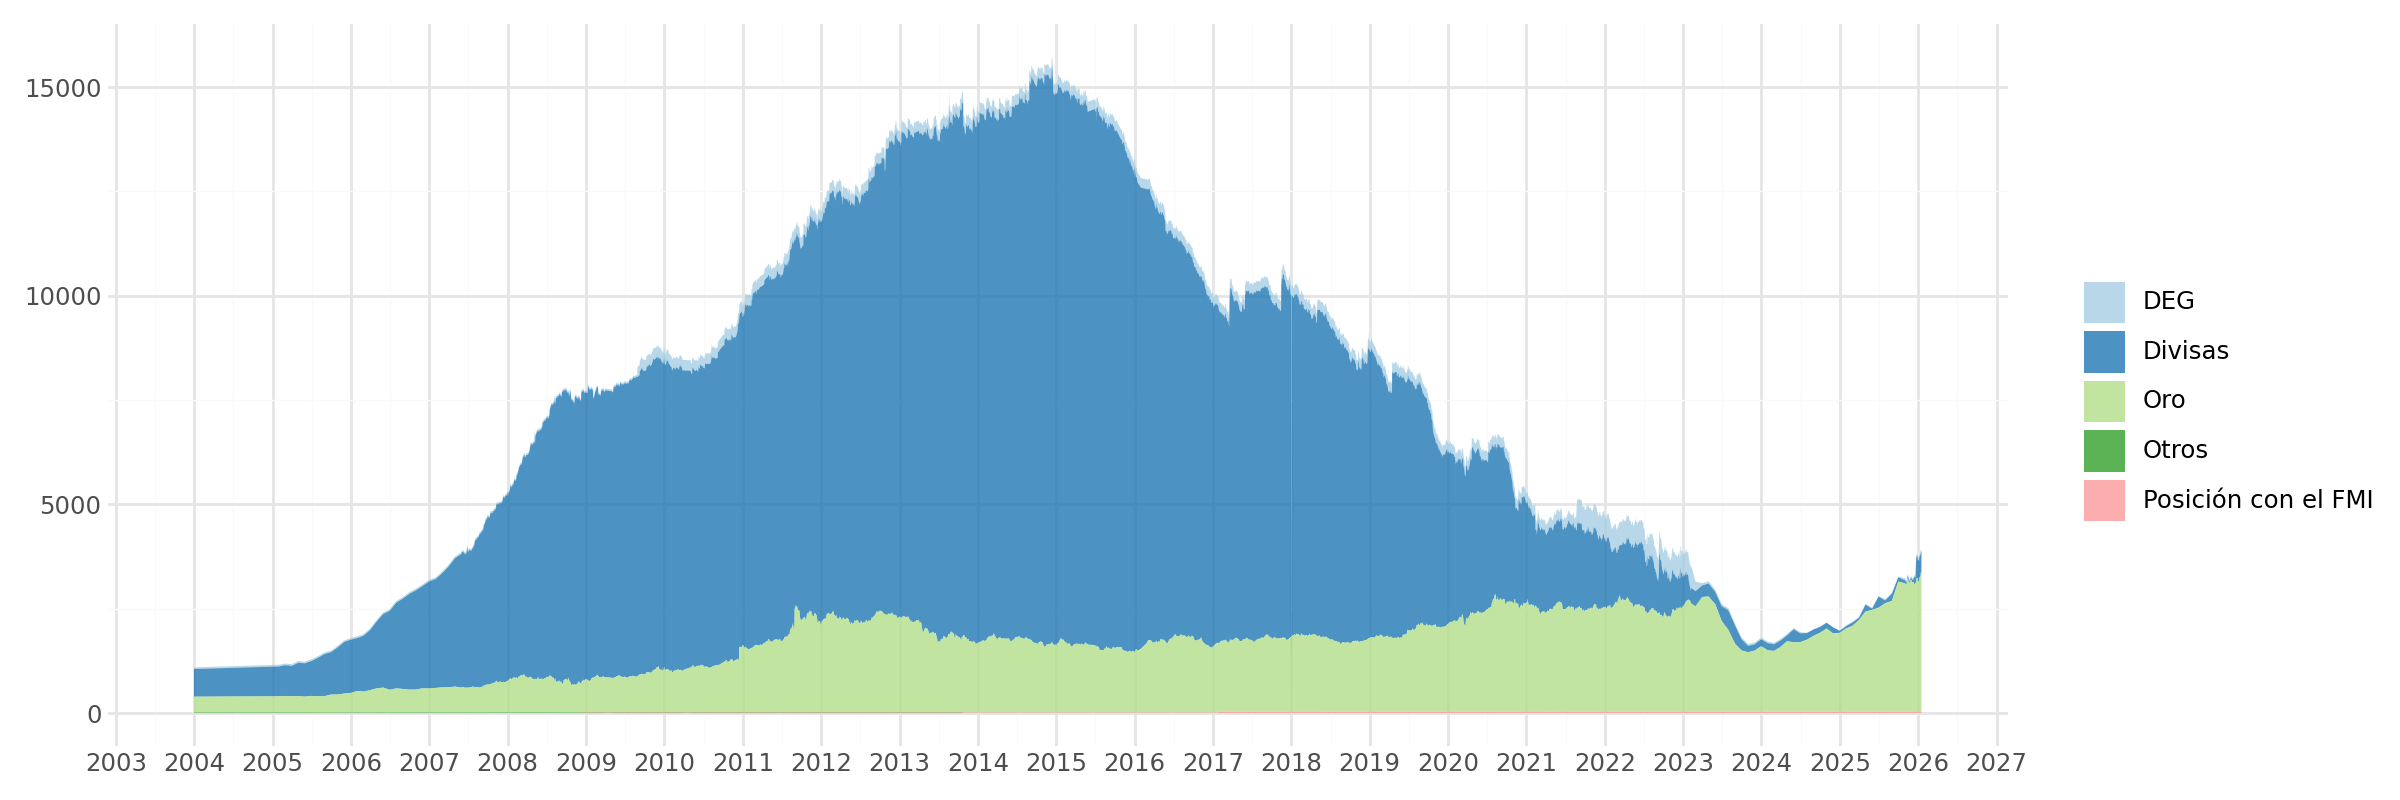

In [365]:
(
    ggplot(
        reservas.fillna(0),
        aes(
            "fecha",
            "valor",
            fill="tipo",
            group="tipo",
        ),
    )
    + geom_area(alpha=0.8)
    + scale_fill_manual(values=palettes.brewer_pal(type="qual", palette="Paired")(n=5))
    + theme_minimal()
    + theme(figure_size=(12, 4))
    + labs(x="", y="", color="", fill="")
    # + scale_y_continuous(labels=percent_format(scale=1))
    + scale_x_datetime(date_breaks="1 year", date_labels="%Y")
)

El número medio de días entre reportes por año.

In [377]:
rdf = reservas.pivot_table(index="fecha", columns="tipo", values="valor").reset_index()
rdf["vacio"] = rdf.fecha.diff().dt.days
rdf[rdf.vacio.notna()].groupby(pd.Grouper(key="fecha", freq="YE")).vacio.mean()

fecha
2005-12-31    60.916667
2006-12-31    30.416667
2007-12-31     2.588652
2008-12-31     1.557447
2009-12-31     1.644144
2010-12-31     1.559829
2011-12-31     1.425781
2012-12-31     1.506173
2013-12-31     1.495902
2014-12-31     1.448413
2015-12-31     1.705607
2016-12-31     1.726415
2017-12-31     1.514523
2018-12-31     1.442688
2019-12-31     1.442688
2020-12-31     1.570815
2021-12-31     1.465863
2022-12-31     1.425781
2023-12-31     9.864865
2024-12-31    30.500000
2025-12-31     9.125000
2026-12-31     1.600000
Freq: YE-DEC, Name: vacio, dtype: float64

Y el porcentaje de días en cada año donde contamos con información.

In [378]:
total = pd.DataFrame({"year": range(2005, 2027)})
total["días"] = pd.to_datetime(total["year"], format="%Y").dt.is_leap_year.map(
    {True: 366, False: 365}
)
total = pd.concat(
    [total.set_index("year"), rdf.fecha.dt.year.value_counts().rename("reportados")], axis=1
).dropna().sort_index().astype(int)
total["cobertura"] = (total.reportados / total.días) * 100
total

,días,reportados,cobertura
2005,365,12,3.287671
2006,365,12,3.287671
2007,365,141,38.630137
2008,366,235,64.207650
2009,365,222,60.821918
2010,365,234,64.109589
2011,365,256,70.136986
2012,366,243,66.393443
2013,365,244,66.849315
2014,365,252,69.041096


El periodo entre 2008 y 2022 es el de mejor cobertura (más del 50% de los días) y los mejores años son 2011 y 2022, donde el Banco llega a reportar valores para 70% de los días del año.

Finalmente guardo este dataset en múltiples formatos.

In [379]:
reservas = reservas.sort_values(["fecha", "tipo"])
reservas

,tipo,fecha,valor
474,DEG,2003-12-31,40.268773
473,Divisas,2003-12-31,663.301314
475,Oro,2003-12-31,379.407355
476,Otros,2003-12-31,13.140502
592,DEG,2005-01-31,40.611767
...,...,...,...
938,Posición con el FMI,2026-01-15,35.625081
469,DEG,2026-01-16,39.527795
234,Divisas,2026-01-16,486.750165
704,Oro,2026-01-16,3344.772988


In [381]:
reservas.to_parquet("reservas.parquet", index=False)
reservas.to_csv("reservas.csv", index=False)
reservas.to_excel("reservas.xlsx", index=False)